In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

import shapely
from shapely import wkt, box

import json

import seaborn as sns

from shapely.geometry import Point, LineString

import os

import numpy as np

from scipy.stats import pearsonr, spearmanr

In [2]:
from utils import helper_meta

In [3]:
path = '../data/data_meta/'

In [4]:
df_crisis = pd.read_parquet(os.path.join(path, 'population_crisis/df_crisis_adm.parquet'))
df_crisis['geometry'] = df_crisis['geometry'].apply(lambda x: wkt.loads(str(x)))
df_crisis = gpd.GeoDataFrame(df_crisis, geometry='geometry', crs='EPSG:4326')

chile_border_adm0 = gpd.read_file(os.path.join(path, 'borders/chl_admbnda_adm0_bcn_20211008.shp'))
chile_border_adm1 = gpd.read_file(os.path.join(path, 'borders/chl_admbnda_adm1_bcn_20211008.shp'))
chile_border_adm3 = gpd.read_file(os.path.join(path, 'borders/chl_admbnda_adm3_bcn_20211008.shp'))

In [5]:
geo_antennas = gpd.read_file('../data/affected_btsid/affected_btsid.shp')

warned_towers = pd.read_csv('../data/warned_towers.csv')

data_cdr = pd.read_parquet('../data/fires_valpo_15minintervals_part000000000000.parquet')
data_cdr = data_cdr[data_cdr['interval_start'] >= '2024-01-19'].reset_index(drop=True)
data_cdr['date'] = data_cdr.interval_start.dt.date
data_cdr['weekday'] = data_cdr.interval_start.dt.weekday
data_cdr['hour'] = data_cdr.interval_start.dt.hour
data_cdr['minute'] = data_cdr.interval_start.dt.minute

In [6]:
df_crisis=helper_meta.update_timezone(df_crisis, 'crisis')

Time Zone: America/Santiago


In [7]:
df_crisis5 = df_crisis[df_crisis.ADM1_PCODE == 'CL05'].reset_index(drop=True)
df_crisis5.crs='4326'

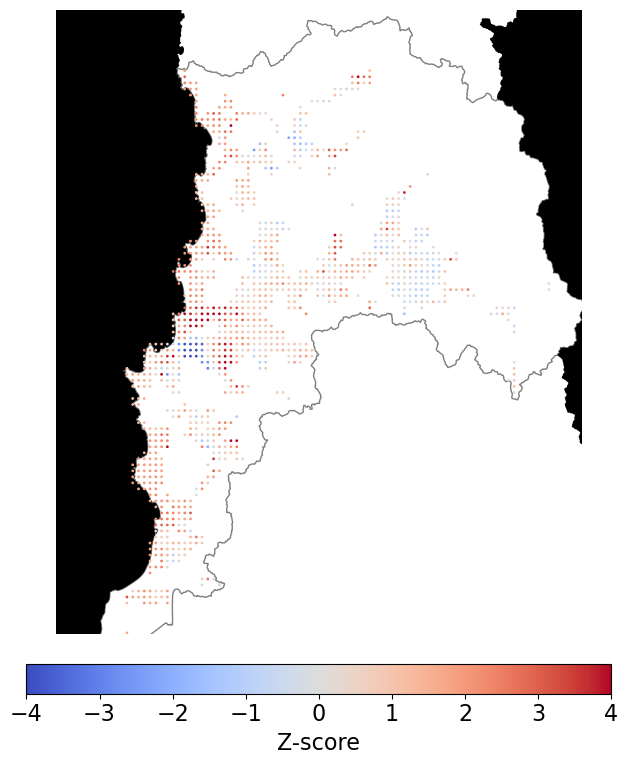

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))  

chile_border_adm0.plot(color='white', ax=ax)
chile_border_adm1[chile_border_adm1['ADM1_ES'] == 'Región de Valparaíso'].plot(color='white', ax=ax, alpha=0.5, edgecolor='black')
df_crisis5[df_crisis5.date_time=='2024-02-04 05:00'].plot(ax=ax, markersize=1, alpha=1, 
                                                          column='z_score', legend=True, cmap='coolwarm',
                                                          legend_kwds={'label': 'Z-score', 'orientation': 'horizontal', 
                                                                       'shrink': 0.5, 'pad': 0.04})


xMin, yMin, xMax, yMax = chile_border_adm0.total_bounds
box_pl = gpd.GeoDataFrame(geometry=[box(xMin, yMin, xMax, yMax)], crs=chile_border_adm0.crs)
box_pl.plot(ax=ax, color='black', zorder=0)

ax.set_ylim( -33.9, -32)
ax.set_xlim(-72, -70)


plt.axis('off')

# Accessing the colorbar object
cbar = ax.get_figure().get_axes()[1]

cbar.tick_params(labelsize=16)
cbar.set_xlabel('Z-score', fontsize=16)

plt.tight_layout()

# plt.savefig('df_crisis5.png', dpi=300)

plt.show();

In [9]:
gdf_grid=helper_meta.define_grid(df_crisis5, grid_size = 2400)

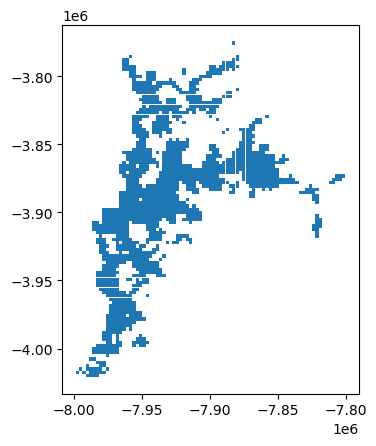

In [10]:
gdf_grid.plot();

In [11]:
gdf_grid = gdf_grid.to_crs(4326)

In [12]:
df_crisis5=df_crisis5.sjoin(gdf_grid, predicate='intersects', how='left').drop('index_right', axis=1)
df_crisis5 = df_crisis5.merge(gdf_grid, on='id', how='left', suffixes=['_point', '_cell'])
df_crisis5 = gpd.GeoDataFrame(df_crisis5, geometry='geometry_cell', crs='3857')

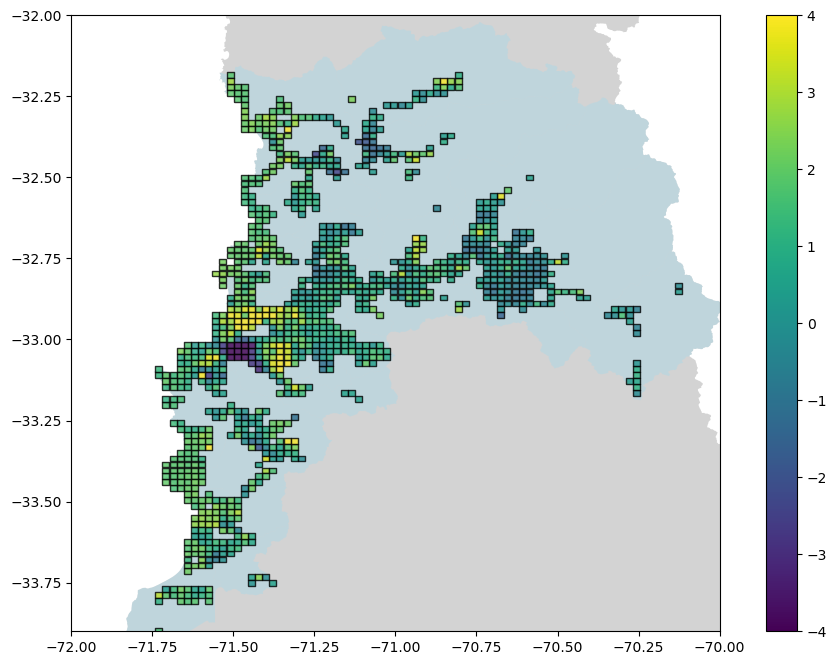

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))  

chile_border_adm0.plot(color='lightgray', ax=ax)
chile_border_adm3[chile_border_adm3['ADM1_ES'] == 'Región de Valparaíso'].plot(color='lightblue', ax=ax, alpha=0.5)
df_crisis5[df_crisis5.date_time=='2024-02-04 05:00'].plot(ax=ax, markersize=1, alpha=0.8, 
                                                          column='z_score', legend=True, edgecolor='black')

ax.set_ylim( -33.9, -32)
ax.set_xlim(-72, -70)

plt.show();

In [14]:
geo_antennas=geo_antennas[geo_antennas.bts_id.isin(data_cdr.bts_id.unique())].reset_index(drop=True)

gdf_grid5 = gdf_grid[gdf_grid.intersects(chile_border_adm1[chile_border_adm1['ADM1_PCODE'] == 'CL05'].geometry.to_crs(4326).iloc[0])].reset_index(drop=True)

In [15]:
gdf_grid5=gdf_grid5.to_crs(3857)
geo_antennas=geo_antennas.to_crs(3857)
geo_antennas = geo_antennas.sjoin(gdf_grid5, predicate='intersects', how='left').drop('index_right', axis=1)
geo_antennas=geo_antennas.to_crs(4326)
gdf_grid5=gdf_grid5.to_crs(4326)

In [16]:
geo_antennas=geo_antennas.to_crs(3857)
gdf_grid5=gdf_grid5.to_crs(3857)

geo_antennas_missing = (geo_antennas[geo_antennas.id.isna()].sjoin_nearest(gdf_grid5, how='left',max_distance=10,
                                                   distance_col='distances')
                        .drop('index_right', axis=1)
                        .rename(columns={'id_right':'id_close'}))

geo_antennas = pd.merge(geo_antennas, geo_antennas_missing[['id_close', 'distances']], left_index=True, right_index=True, how='left')
geo_antennas.loc[geo_antennas['id'].isna(), 'id'] = geo_antennas['id_close']
geo_antennas = geo_antennas.drop(columns=['id_close'])

In [17]:
data_cdr_b = data_cdr[data_cdr['interval_start'] < '2024-02-02'].reset_index(drop=True)
data_cdr_b = data_cdr_b.groupby(['bts_id', 'weekday', 'hour', 'minute'])['unique_phone_ids'].mean().reset_index()

data_cdr_c = data_cdr[data_cdr['interval_start'] >= '2024-02-02'].reset_index(drop=True)

data_merged = data_cdr_b.merge(data_cdr_c[['date', 'weekday', 'hour', 'minute', 'bts_id', 'unique_phone_ids', 'interval_start']], 
                 on=['weekday', 'hour', 'minute', 'bts_id'], 
                 how='left', suffixes=['_baseline', '_crisis'])
data_merged = data_merged.sort_values(['bts_id', 'interval_start']).reset_index(drop=True)

In [18]:
data_merged['meta_period'] = data_merged['hour'].apply(lambda x: 5 if ((x<13)&(x>=5)) else (13 if ((x<21)&(x>=5)) else 21))
data_combo = data_merged.groupby(['bts_id', 'date', 'weekday', 'meta_period']).agg({'unique_phone_ids_baseline':'mean',
                                                                            'unique_phone_ids_crisis':'mean'}).reset_index()
data_combo['diff'] = data_combo['unique_phone_ids_crisis']-data_combo['unique_phone_ids_baseline']
data_combo['diff_perc'] = data_combo['diff']/data_combo['unique_phone_ids_baseline']*100

In [ ]:
def z_score(row):
    relevant_data = data_merged.loc[(data_merged['bts_id'] == row['bts_id']) &
                                    (data_merged['weekday'] == row['weekday']) &
                                    (data_merged['meta_period'] == row['meta_period']), 'unique_phone_ids_baseline']
    
    std = relevant_data.std() if len(relevant_data) > 1 else None  # Calculate standard deviation only if there's enough data
    z_score_ = (row['unique_phone_ids_crisis'] - row['unique_phone_ids_baseline']) / std if std is not None else None

    return std, z_score_

In [ ]:
# Apply the function to each row of data_combo
data_combo[['std', 'z_score']] = data_combo.apply(z_score, axis=1, result_type='expand')

In [ ]:
data_combo['z_score_clipped'] = data_combo['z_score'].clip(lower=-4, upper=4)

In [24]:
# data_combo.to_csv('../data_created/meta_data_combo.csv')

In [67]:
data_combo = pd.read_csv('../data_created/meta_data_combo.csv')

In [68]:
data_combo = data_combo.merge(geo_antennas[['bts_id', 'id']], on='bts_id', how='left')
data_combo = data_combo.merge(gdf_grid[['id', 'geometry']], on='id', how='left')
data_combo = gpd.GeoDataFrame(data_combo, geometry='geometry', crs='4236')

In [69]:
data_grids = data_combo.groupby(['id', 'date', 'meta_period']).agg({
                             'unique_phone_ids_baseline':'sum',
                             'unique_phone_ids_crisis':'sum',
                             'std':'mean',
                             'weekday':'first',
                             'geometry':'first'}).reset_index()

In [70]:
data_grids['diff'] = data_grids['unique_phone_ids_crisis']-data_grids['unique_phone_ids_baseline']
data_grids['diff_perc'] = data_grids['diff']/data_grids['unique_phone_ids_baseline']*100

In [71]:
data_grids['z_score'] = data_grids['diff']/data_grids['std']
data_grids['z_score_clipped'] = data_grids['z_score'].clip(lower=-4, upper=4)

In [72]:
data_grids['interval_start'] = pd.to_datetime(data_grids['date'].astype(str) + ' ' + data_grids['meta_period'].astype(str), format='%Y-%m-%d %H')

In [73]:
data_grids['interval_start'] = data_grids['interval_start'].dt.tz_localize('America/Santiago')

In [74]:
final_tel = data_grids[['id', 'interval_start', 'diff_perc', 'z_score', 'z_score_clipped', 'unique_phone_ids_baseline', 'unique_phone_ids_crisis']]
final_tel_filtered=final_tel[final_tel['interval_start'] == '2024-02-08 13:00:00'].drop('interval_start', axis=1).reset_index(drop=True)

In [75]:
final_meta = df_crisis5[['id', 'date_time', 'percent_change', 'z_score', 'n_baseline', 'n_crisis']]
final_meta_filtered=final_meta[final_meta['date_time'] == '2024-02-08 13:00:00'].dropna().reset_index(drop=True)

In [76]:
merged_final = final_tel_filtered.merge(final_meta_filtered, on='id', suffixes=['_tel','_meta'])

In [77]:
merged_final['unique_phone_ids_baseline'].corr(merged_final['n_baseline'], method='pearson')

0.7698552724560838

In [78]:
final_tel = data_grids[['id', 'interval_start', 'diff_perc', 'z_score', 'z_score_clipped', 'unique_phone_ids_baseline', 'unique_phone_ids_crisis']]
final_tel = final_tel[final_tel['interval_start'] == '2024-02-08 13:00:00'].drop('interval_start', axis=1).reset_index(drop=True)

final_meta = df_crisis5[['id', 'date_time', 'percent_change', 'z_score', 'n_baseline', 'n_crisis']]
final_meta = final_meta[final_meta['date_time'] == '2024-02-08 13:00:00'].drop('date_time', axis=1).reset_index(drop=True)

merged_final = final_tel.merge(final_meta, on='id', suffixes=['_tel', '_meta']).dropna().reset_index(drop=True)

In [79]:
merged_final['unique_phone_ids_baseline'].corr(merged_final['n_baseline'], method='pearson')

0.7698552724560838

In [80]:
plt.rcParams.update({'font.size': 13, 'font.style': 'normal', 'figure.facecolor':'white'})

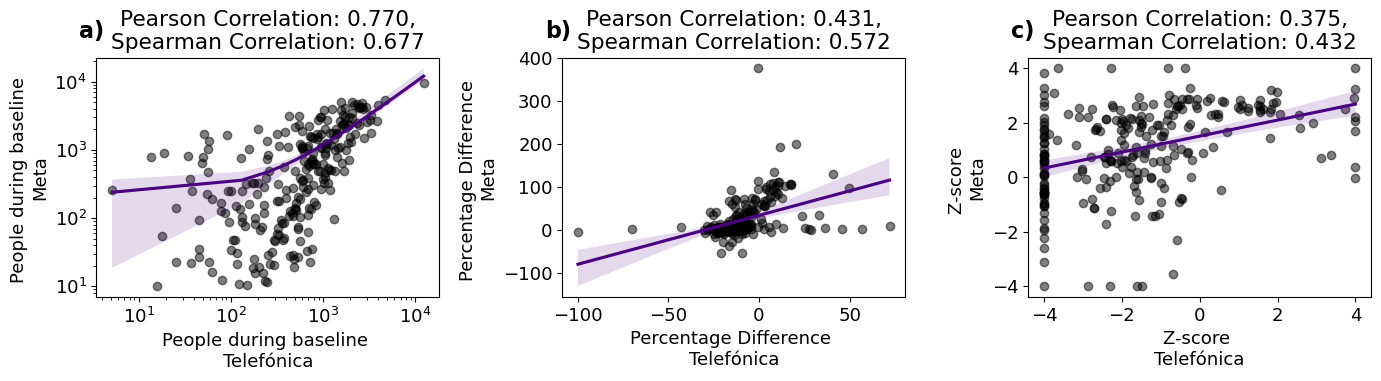

In [81]:
fig, axs = plt.subplots(1, 3, figsize=(14,4))

sns.regplot(ax=axs[0], 
            x = merged_final.unique_phone_ids_baseline, y = merged_final.n_baseline,
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "indigo"},
            ci = 95)
axs[0].set_xlabel('People during baseline \nTelefónica')
axs[0].set_ylabel('People during baseline \nMeta')

axs[0].set(xscale='log', yscale='log')

# Calculate correlation coefficient
correlation_coefficient_p = merged_final['unique_phone_ids_baseline'].corr(merged_final['n_baseline'], method='pearson')
correlation_coefficient_s = merged_final['unique_phone_ids_baseline'].corr(merged_final['n_baseline'], method='spearman')
axs[0].set_title(f'Pearson Correlation: {correlation_coefficient_p:.3f},\nSpearman Correlation: {correlation_coefficient_s:.3f}')

sns.regplot(ax=axs[1], 
            x = merged_final.diff_perc, y = merged_final.percent_change,
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "indigo"},
            ci = 95)
axs[1].set_xlabel('Percentage Difference \nTelefónica')
axs[1].set_ylabel('Percentage Difference \nMeta')

# Calculate correlation coefficient
correlation_coefficient_p = merged_final['diff_perc'].corr(merged_final['percent_change'], method='pearson')
correlation_coefficient_s = merged_final['diff_perc'].corr(merged_final['percent_change'], method='spearman')
axs[1].set_title(f'Pearson Correlation: {correlation_coefficient_p:.3f},\nSpearman Correlation: {correlation_coefficient_s:.3f}')

sns.regplot(ax=axs[2], 
            x = merged_final.z_score_clipped, y = merged_final.z_score_meta,
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "indigo"},
            ci = 95)
axs[2].set_xlabel('Z-score \nTelefónica')
axs[2].set_ylabel('Z-score \nMeta')

# Calculate correlation coefficient
correlation_coefficient_p = merged_final['z_score_clipped'].corr(merged_final['z_score_meta'], method='pearson')
correlation_coefficient_s = merged_final['z_score_clipped'].corr(merged_final['z_score_meta'], method='spearman')
axs[2].set_title(f'Pearson Correlation: {correlation_coefficient_p:.3f},\nSpearman Correlation: {correlation_coefficient_s:.3f}')

plt.tight_layout()

plots_l = ['a)', 'b)', 'c)']
for ia, ax in enumerate(fig.axes): 
    x,y = -0.05,1.06
    ax.text(x,y,  plots_l[ia],
        color = 'k',#'lightgreen',
        horizontalalignment='left',
        verticalalignment='bottom',
        weight = 'bold',
        transform=ax.transAxes,fontsize = 16)

plt.savefig('../visuals_created/correlations_February8_13.pdf', bbox_inches = 'tight')

plt.show()

In [82]:
from matplotlib.lines import Line2D

In [83]:
saturated_blue='#0072B2'
saturated_orange='#D55E00'

In [84]:
def get_time_correlation(df_tel, df_meta, column1, column2):
    correlation_results = pd.DataFrame(columns=['datetime', 'pearson_correlation', 'spearman_correlation',
                                                'pearson_p_value', 'spearman_p_value'])

    for datetime in df_tel[(df_tel['interval_start'] >= '2024-02-04') & (df_tel['interval_start'] <= '2024-02-18')]['interval_start'].unique():
        
        final_tel = df_tel[['id', 'interval_start', 'diff_perc', 'z_score', 'z_score_clipped', 'unique_phone_ids_baseline', 'unique_phone_ids_crisis']]
        final_tel = final_tel[final_tel['interval_start'] == datetime].drop('interval_start', axis=1).reset_index(drop=True)
    
        final_meta = df_meta[['id', 'date_time', 'percent_change', 'z_score', 'n_baseline', 'n_crisis']]
        final_meta = final_meta[final_meta['date_time'] == datetime].drop('date_time', axis=1).reset_index(drop=True)
    
        merged_final = final_tel.merge(final_meta, on='id', suffixes=['_tel', '_meta']).dropna().reset_index(drop=True)
    
    
        if not merged_final.empty:
            # Calculate Pearson correlation and p-value
            pearson_corr, pearson_p = pearsonr(merged_final[column1], merged_final[column2])
            # Calculate Spearman correlation and p-value
            spearman_corr, spearman_p = spearmanr(merged_final[column1], merged_final[column2])
    
            # Create a new DataFrame for the current result
            current_result = pd.DataFrame({
                'datetime': [datetime],
                'pearson_correlation': [pearson_corr],
                'spearman_correlation': [spearman_corr],
                'pearson_p_value': [pearson_p],
                'spearman_p_value': [spearman_p]
            })
    
            # Concatenate the current result with the results DataFrame
            correlation_results = pd.concat([correlation_results, current_result], ignore_index=True)

    # Melt the correlation results for long format with correlation values
    correlation_melted = correlation_results.melt(
        id_vars=['datetime'], 
        value_vars=['pearson_correlation', 'spearman_correlation'], 
        var_name='correlation_type', 
        value_name='correlation_value'
    )
    
    pvalue_melted = correlation_results.melt(
        id_vars=['datetime'], 
        value_vars=['pearson_p_value', 'spearman_p_value'], 
        var_name='pvalue_type', 
        value_name='p_value'
    )
    
    # Map correlation types to their corresponding p-value types
    correlation_melted['pvalue_type'] = correlation_melted['correlation_type'].apply(
        lambda x: 'pearson_p_value' if 'pearson' in x else 'spearman_p_value'
    )
    
    # Merge the correlation and p-value DataFrames on datetime and pvalue_type
    result_melted = pd.merge(correlation_melted, pvalue_melted, on=['datetime', 'pvalue_type'])


    # Add statistical significance column
    result_melted['significance'] = result_melted['p_value'].apply(
        lambda x: '<0.001' if x < 0.001 else ('<0.01' if x < 0.01 else ('<0.05' if x < 0.05 else '>=0.05')))

    return result_melted


In [85]:
correlation_results=get_time_correlation(data_grids, df_crisis5, 'unique_phone_ids_baseline', 'n_baseline')

/tmp/ipykernel_40492/2030380496.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results = pd.concat([correlation_results, current_result], ignore_index=True)


In [86]:
marker_styles = {
    '>=0.05': "+",    # Square
    '<0.05': "^",     # Triangle
    '<0.01': "^",     # Triangle
    '<0.001': "o"     # Circle
}

/tmp/ipykernel_40492/2030380496.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results = pd.concat([correlation_results, current_result], ignore_index=True)
/tmp/ipykernel_40492/2030380496.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results = pd.concat([correlation_results, current_result], ignore_index=True)
/tmp/ipykernel_40492/2030380496.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future 

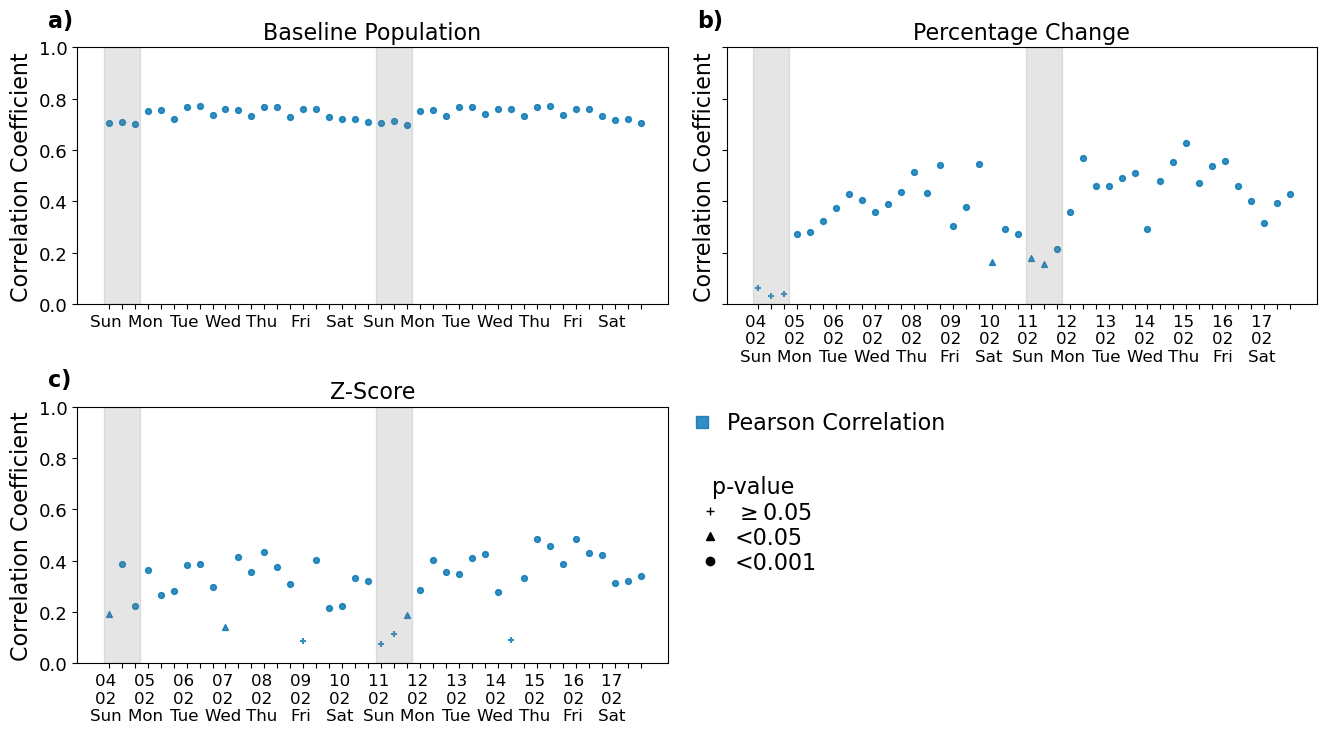

In [87]:
fig, axs = plt.subplot_mosaic([
    ['a', 'b',],
    ['c', 'ee']], 
    #layout="constrained"
    figsize =(16, 8), #height_ratios=[1.5,1],width_ratios=[1,1,1],
                             sharey=True, gridspec_kw={'wspace':0.1, 'hspace':0.4})

for e in ['ee']: fig.delaxes(axs[e])

# First plot
correlation_results=get_time_correlation(data_grids, df_crisis5, 'unique_phone_ids_baseline', 'n_baseline')

for _, row in correlation_results.iterrows():
    if 'pearson' in row['correlation_type']:
        axs['a'].scatter(row['datetime'], row['correlation_value'],
                         marker=marker_styles.get(row['significance']), s=18,
                         color=saturated_blue, alpha=0.8)
    # elif 'spearman' in row['correlation_type']:
    #     axs['a'].scatter(row['datetime'], row['correlation_value'],
    #                      marker=marker_styles.get(row['significance']), s=15,
    #                      color=saturated_orange, alpha=0.8)
axs['a'].axvspan('2024-02-04 02:00:00-03:00', '2024-02-05 00:00:00-03:00', color='gray', alpha=0.2)
axs['a'].axvspan('2024-02-11 02:00:00-03:00', '2024-02-12 00:00:00-03:00', color='gray', alpha=0.2)

axs['a'].set_title('Baseline Population', fontsize=16)
axs['a'].set_ylabel('Correlation Coefficient',  fontsize=16)
axs['a'].set_xlabel('')
axs['a'].set_ylim(0, 1)

unique_dates = correlation_results.drop_duplicates(subset=['datetime'])['datetime'].unique()
xticklabels1 = [date.strftime('%a ') if i % 3 == 0 else '' for i, date in enumerate(unique_dates)]
xticklabels2 = [date.strftime('%d \n%m \n%a ') if i % 3 == 0 else '' for i, date in enumerate(unique_dates)]

axs['a'].set_xticks(unique_dates)
axs['a'].set_xticklabels(xticklabels1, fontsize=12)

# Second plot
correlation_results=get_time_correlation(data_grids, df_crisis5, 'percent_change', 'diff_perc')

for _, row in correlation_results.iterrows():
    if 'pearson' in row['correlation_type']:
        axs['b'].scatter(row['datetime'], row['correlation_value'],
                         marker=marker_styles.get(row['significance']), s=18,
                         color=saturated_blue, alpha=0.8)
    # elif 'spearman' in row['correlation_type']:
    #     axs['b'].scatter(row['datetime'], row['correlation_value'],
    #                      marker=marker_styles.get(row['significance']), s=15,
    #                      color=saturated_orange, alpha=0.8)

axs['b'].axvspan('2024-02-04 02:00:00-03:00', '2024-02-05 00:00:00-03:00', color='gray', alpha=0.2)
axs['b'].axvspan('2024-02-11 02:00:00-03:00', '2024-02-12 00:00:00-03:00', color='gray', alpha=0.2)
        
axs['b'].set_title('Percentage Change', fontsize=16)
axs['b'].set_ylabel('Correlation Coefficient', fontsize=16)
axs['b'].set_xlabel('')

axs['b'].set_xticks(unique_dates)
axs['b'].set_xticklabels(xticklabels2, fontsize=12)

# Third plot
correlation_results=get_time_correlation(data_grids, df_crisis5, 'z_score_meta', 'z_score_clipped')

for _, row in correlation_results.iterrows():
    if 'pearson' in row['correlation_type']:
        axs['c'].scatter(row['datetime'], row['correlation_value'],
                         marker=marker_styles.get(row['significance']), s=18,
                         color=saturated_blue, alpha=0.8)
    # elif 'spearman' in row['correlation_type']:
    #     axs['c'].scatter(row['datetime'], row['correlation_value'],
    #                      marker=marker_styles.get(row['significance']), s=15,
    #                      color=saturated_orange, alpha=0.8)

axs['c'].axvspan('2024-02-04 02:00:00-03:00', '2024-02-05 00:00:00-03:00', color='gray', alpha=0.2)
axs['c'].axvspan('2024-02-11 02:00:00-03:00', '2024-02-12 00:00:00-03:00', color='gray', alpha=0.2)

axs['c'].set_title('Z-Score', fontsize=16)
axs['c'].set_ylabel('Correlation Coefficient', fontsize=16)
axs['c'].set_xlabel('')

axs['c'].set_xticks(unique_dates)
axs['c'].set_xticklabels(xticklabels2, fontsize=12)

# Legend
# c_differences   =[(Line2D([0],[0], marker='s', color=c, markerfacecolor=c,ls='',  
#                   markersize=8, alpha=0.8, label=mod)) for c,mod in 
#                   zip([saturated_blue, saturated_orange],
#                       ['Pearson Correlation','Spearman Correlation'])]

c_differences   =[(Line2D([0],[0], marker='s', color=c, markerfacecolor=c,ls='',  
                  markersize=8, alpha=0.8, label=mod)) for c,mod in 
                  zip([saturated_blue],
                      ['Pearson Correlation'])]

markers =[(Line2D([0],[0], marker=m, color='black', markerfacecolor='black',ls='',  
                  label=mod)) for m,mod in zip(['+', '^', 'o'],[r'$\geq$0.05','<0.05', '<0.001'])]

fig.legend(handles=c_differences,bbox_to_anchor=(0.68,0.45), fontsize = 16, 
           title= '', frameon=False,columnspacing=0.5, handletextpad=0.1,labelspacing=0.1)
fig.legend(handles=markers,bbox_to_anchor=(0.6,0.37), fontsize = 16, title= 'p-value',
           ncols= 1, frameon=False,columnspacing=0.8, handletextpad=0.1,labelspacing=0.1, title_fontsize=16)


plots_l = ['a)', 'b)', 'c)']
for ia, ax in enumerate(fig.axes): 
    x,y = -0.05,1.06
    ax.text(x,y,  plots_l[ia],
        color = 'k',#'lightgreen',
        horizontalalignment='left',
        verticalalignment='bottom',
        weight = 'bold',
        transform=ax.transAxes,fontsize = 16)

plt.savefig('../visuals_created/correlations_overtime_pearson.pdf', bbox_inches = 'tight')

plt.show();

/tmp/ipykernel_40492/2030380496.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results = pd.concat([correlation_results, current_result], ignore_index=True)
/tmp/ipykernel_40492/2030380496.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results = pd.concat([correlation_results, current_result], ignore_index=True)


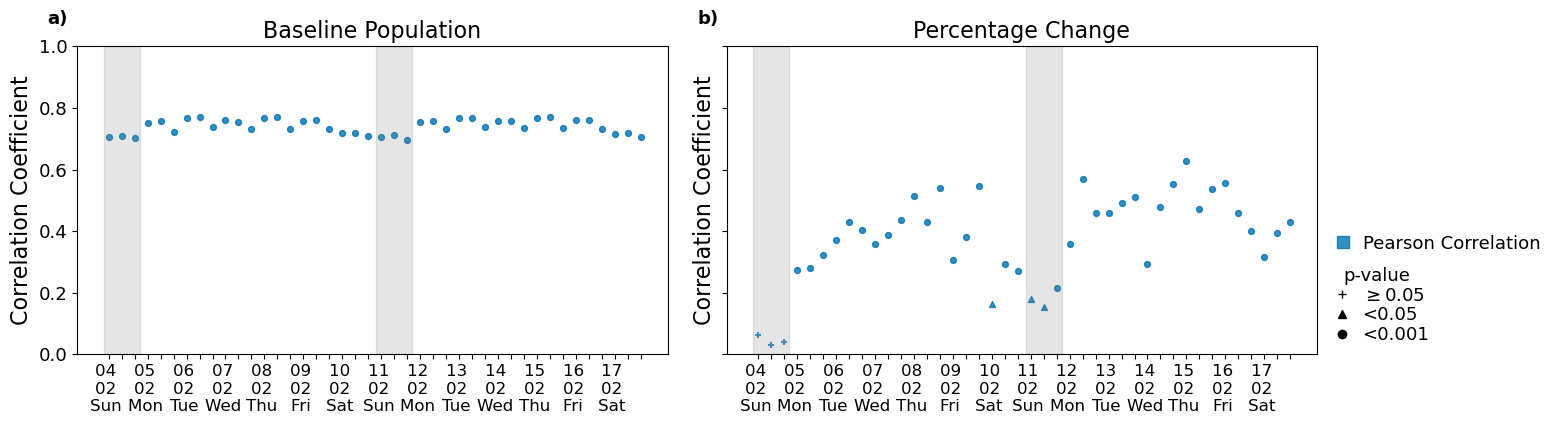

In [88]:
fig, axs = plt.subplot_mosaic([
    ['a', 'b',]],
    # ['c', 'ee']], 
    #layout="constrained"
    figsize =(16, 4), #height_ratios=[1.5,1],width_ratios=[1,1,1],
                             sharey=True, gridspec_kw={'wspace':0.1, 'hspace':0.4})

# for e in ['ee']: fig.delaxes(axs[e])

# First plot
correlation_results=get_time_correlation(data_grids, df_crisis5, 'unique_phone_ids_baseline', 'n_baseline')

for _, row in correlation_results.iterrows():
    if 'pearson' in row['correlation_type']:
        axs['a'].scatter(row['datetime'], row['correlation_value'],
                         marker=marker_styles.get(row['significance']), s=18,
                         color=saturated_blue, alpha=0.8)
    # elif 'spearman' in row['correlation_type']:
    #     axs['a'].scatter(row['datetime'], row['correlation_value'],
    #                      marker=marker_styles.get(row['significance']), s=15,
    #                      color=saturated_orange, alpha=0.8)
axs['a'].axvspan('2024-02-04 02:00:00-03:00', '2024-02-05 00:00:00-03:00', color='gray', alpha=0.2)
axs['a'].axvspan('2024-02-11 02:00:00-03:00', '2024-02-12 00:00:00-03:00', color='gray', alpha=0.2)

axs['a'].set_title('Baseline Population', fontsize=16)
axs['a'].set_ylabel('Correlation Coefficient', fontsize=16)
axs['a'].set_xlabel('')
axs['a'].set_ylim(0, 1)

unique_dates = correlation_results.drop_duplicates(subset=['datetime'])['datetime'].unique()
xticklabels1 = [date.strftime('%a ') if i % 3 == 0 else '' for i, date in enumerate(unique_dates)]
xticklabels2 = [date.strftime('%d \n%m \n%a ') if i % 3 == 0 else '' for i, date in enumerate(unique_dates)]

axs['a'].set_xticks(unique_dates)
axs['a'].set_xticklabels(xticklabels2, fontsize=12)

# Second plot
correlation_results=get_time_correlation(data_grids, df_crisis5, 'percent_change', 'diff_perc')

for _, row in correlation_results.iterrows():
    if 'pearson' in row['correlation_type']:
        axs['b'].scatter(row['datetime'], row['correlation_value'],
                         marker=marker_styles.get(row['significance']), s=18,
                         color=saturated_blue, alpha=0.8)
    # elif 'spearman' in row['correlation_type']:
    #     axs['b'].scatter(row['datetime'], row['correlation_value'],
    #                      marker=marker_styles.get(row['significance']), s=15,
    #                      color=saturated_orange, alpha=0.8)

axs['b'].axvspan('2024-02-04 02:00:00-03:00', '2024-02-05 00:00:00-03:00', color='gray', alpha=0.2)
axs['b'].axvspan('2024-02-11 02:00:00-03:00', '2024-02-12 00:00:00-03:00', color='gray', alpha=0.2)
        
axs['b'].set_title('Percentage Change', fontsize=16)
axs['b'].set_ylabel('Correlation Coefficient', fontsize=16)
axs['b'].set_xlabel('')

axs['b'].set_xticks(unique_dates)
axs['b'].set_xticklabels(xticklabels2, fontsize=12)

# # Third plot
# correlation_results=get_time_correlation(data_grids, df_crisis5, 'z_score_meta', 'z_score_clipped')

# for _, row in correlation_results.iterrows():
#     if 'pearson' in row['correlation_type']:
#         axs['c'].scatter(row['datetime'], row['correlation_value'],
#                          marker=marker_styles.get(row['significance']), s=18,
#                          color=saturated_blue, alpha=0.8)
#     # elif 'spearman' in row['correlation_type']:
#     #     axs['c'].scatter(row['datetime'], row['correlation_value'],
#     #                      marker=marker_styles.get(row['significance']), s=15,
#     #                      color=saturated_orange, alpha=0.8)

# axs['c'].axvspan('2024-02-04 02:00:00-03:00', '2024-02-05 00:00:00-03:00', color='gray', alpha=0.2)
# axs['c'].axvspan('2024-02-11 02:00:00-03:00', '2024-02-12 00:00:00-03:00', color='gray', alpha=0.2)

# axs['c'].set_title('Z-Score')
# axs['c'].set_ylabel('Correlation Coefficient')
# axs['c'].set_xlabel('')

# axs['c'].set_xticks(unique_dates)
# axs['c'].set_xticklabels(xticklabels2, fontsize=10)

# Legend
# c_differences   =[(Line2D([0],[0], marker='s', color=c, markerfacecolor=c,ls='',  
#                   markersize=8, alpha=0.8, label=mod)) for c,mod in 
#                   zip([saturated_blue, saturated_orange],
#                       ['Pearson Correlation','Spearman Correlation'])]

c_differences   =[(Line2D([0],[0], marker='s', color=c, markerfacecolor=c,ls='',  
                  markersize=8, alpha=0.8, label=mod)) for c,mod in 
                  zip([saturated_blue],
                      ['Pearson Correlation'])]

markers =[(Line2D([0],[0], marker=m, color='black', markerfacecolor='black',ls='',  
                  label=mod)) for m,mod in zip(['+', '^', 'o'],[r'$\geq$0.05','<0.05', '<0.001'])]

fig.legend(handles=c_differences,bbox_to_anchor=(1.05,0.45), fontsize = 13, 
           title= '', frameon=False,columnspacing=0.5, handletextpad=0.1,labelspacing=0.1)
fig.legend(handles=markers,bbox_to_anchor=(0.98,0.37), fontsize = 13, title= 'p-value',
           ncols= 1, frameon=False,columnspacing=0.8, handletextpad=0.1,labelspacing=0.1)


plots_l = ['a)', 'b)']
for ia, ax in enumerate(fig.axes): 
    x,y = -0.05,1.06
    ax.text(x,y,  plots_l[ia],
        color = 'k',#'lightgreen',
        horizontalalignment='left',
        verticalalignment='bottom',
        weight = 'bold',
        transform=ax.transAxes,fontsize = 13)

plt.savefig('../visuals_created/correlations_overtime_pearson_update.pdf', bbox_inches = 'tight')

plt.show();

/tmp/ipykernel_40492/2030380496.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results = pd.concat([correlation_results, current_result], ignore_index=True)
/tmp/ipykernel_40492/2030380496.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results = pd.concat([correlation_results, current_result], ignore_index=True)
/tmp/ipykernel_40492/2030380496.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future 

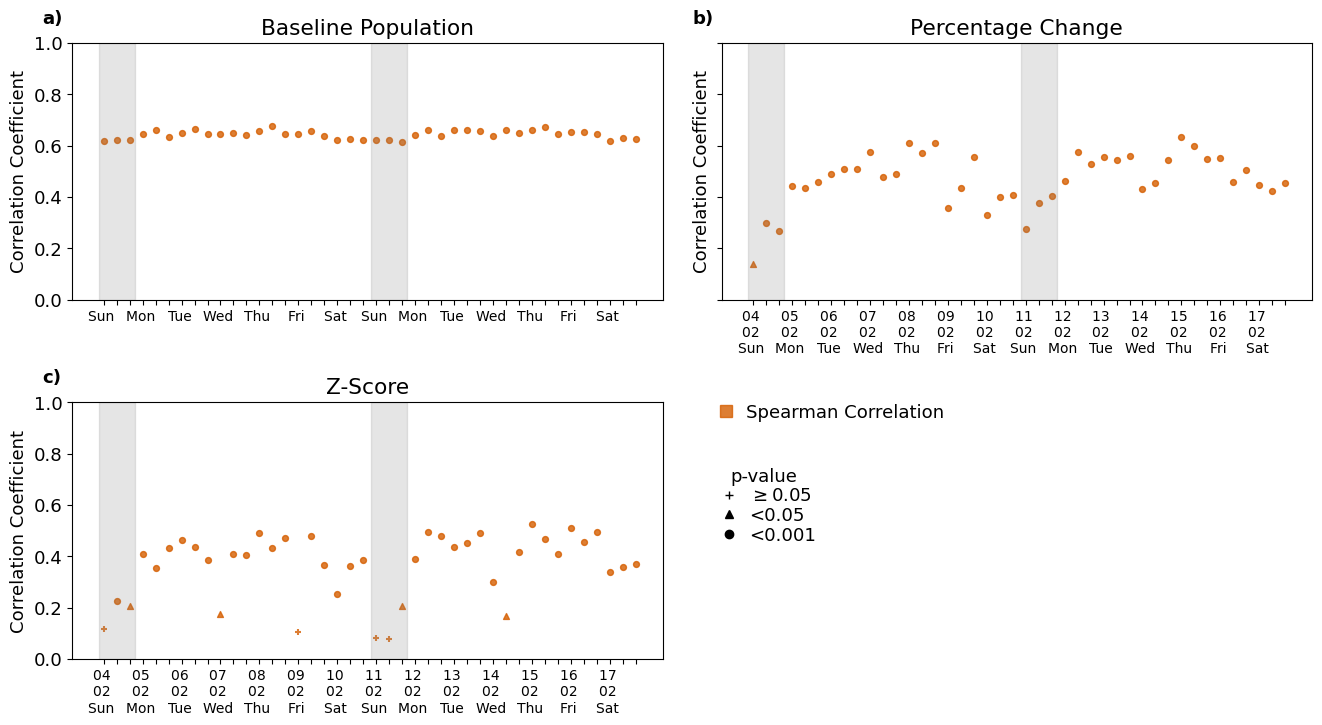

In [89]:
fig, axs = plt.subplot_mosaic([
    ['a', 'b',],
    ['c', 'ee']], 
    #layout="constrained"
    figsize =(16, 8), #height_ratios=[1.5,1],width_ratios=[1,1,1],
                             sharey=True, gridspec_kw={'wspace':0.1, 'hspace':0.4})

for e in ['ee']: fig.delaxes(axs[e])

# First plot
correlation_results=get_time_correlation(data_grids, df_crisis5, 'unique_phone_ids_baseline', 'n_baseline')

for _, row in correlation_results.iterrows():
    if 'spearman' in row['correlation_type']:
        axs['a'].scatter(row['datetime'], row['correlation_value'],
                         marker=marker_styles.get(row['significance']), s=18,
                         color=saturated_orange, alpha=0.8)
    # elif 'spearman' in row['correlation_type']:
    #     axs['a'].scatter(row['datetime'], row['correlation_value'],
    #                      marker=marker_styles.get(row['significance']), s=15,
    #                      color=saturated_orange, alpha=0.8)
axs['a'].axvspan('2024-02-04 02:00:00-03:00', '2024-02-05 00:00:00-03:00', color='gray', alpha=0.2)
axs['a'].axvspan('2024-02-11 02:00:00-03:00', '2024-02-12 00:00:00-03:00', color='gray', alpha=0.2)

axs['a'].set_title('Baseline Population')
axs['a'].set_ylabel('Correlation Coefficient')
axs['a'].set_xlabel('')
axs['a'].set_ylim(0, 1)

unique_dates = correlation_results.drop_duplicates(subset=['datetime'])['datetime'].unique()
xticklabels1 = [date.strftime('%a ') if i % 3 == 0 else '' for i, date in enumerate(unique_dates)]
xticklabels2 = [date.strftime('%d \n%m \n%a ') if i % 3 == 0 else '' for i, date in enumerate(unique_dates)]

axs['a'].set_xticks(unique_dates)
axs['a'].set_xticklabels(xticklabels1, fontsize=10)

# Second plot
correlation_results=get_time_correlation(data_grids, df_crisis5, 'percent_change', 'diff_perc')

for _, row in correlation_results.iterrows():
    if 'spearman' in row['correlation_type']:
        axs['b'].scatter(row['datetime'], row['correlation_value'],
                         marker=marker_styles.get(row['significance']), s=18,
                         color=saturated_orange, alpha=0.8)
    # elif 'spearman' in row['correlation_type']:
    #     axs['b'].scatter(row['datetime'], row['correlation_value'],
    #                      marker=marker_styles.get(row['significance']), s=15,
    #                      color=saturated_orange, alpha=0.8)
axs['b'].axvspan('2024-02-04 02:00:00-03:00', '2024-02-05 00:00:00-03:00', color='gray', alpha=0.2)
axs['b'].axvspan('2024-02-11 02:00:00-03:00', '2024-02-12 00:00:00-03:00', color='gray', alpha=0.2)
        
axs['b'].set_title('Percentage Change')
axs['b'].set_ylabel('Correlation Coefficient')
axs['b'].set_xlabel('')

axs['b'].set_xticks(unique_dates)
axs['b'].set_xticklabels(xticklabels2, fontsize=10)

# Third plot
correlation_results=get_time_correlation(data_grids, df_crisis5, 'z_score_meta', 'z_score_clipped')

for _, row in correlation_results.iterrows():
    if 'spearman' in row['correlation_type']:
        axs['c'].scatter(row['datetime'], row['correlation_value'],
                         marker=marker_styles.get(row['significance']), s=18,
                         color=saturated_orange, alpha=0.8)
    # elif 'spearman' in row['correlation_type']:
    #     axs['c'].scatter(row['datetime'], row['correlation_value'],
    #                      marker=marker_styles.get(row['significance']), s=15,
    #                      color=saturated_orange, alpha=0.8)
axs['c'].axvspan('2024-02-04 02:00:00-03:00', '2024-02-05 00:00:00-03:00', color='gray', alpha=0.2)
axs['c'].axvspan('2024-02-11 02:00:00-03:00', '2024-02-12 00:00:00-03:00', color='gray', alpha=0.2)
        
axs['c'].set_title('Z-Score')
axs['c'].set_ylabel('Correlation Coefficient')
axs['c'].set_xlabel('')

axs['c'].set_xticks(unique_dates)
axs['c'].set_xticklabels(xticklabels2, fontsize=10)

# Legend
# c_differences   =[(Line2D([0],[0], marker='s', color=c, markerfacecolor=c,ls='',  
#                   markersize=8, alpha=0.8, label=mod)) for c,mod in 
#                   zip([saturated_blue, saturated_orange],
#                       ['Pearson Correlation','Spearman Correlation'])]

c_differences   =[(Line2D([0],[0], marker='s', color=c, markerfacecolor=c,ls='',  
                  markersize=8, alpha=0.8, label=mod)) for c,mod in 
                  zip([saturated_orange],
                      ['Spearman Correlation'])]

markers =[(Line2D([0],[0], marker=m, color='black', markerfacecolor='black',ls='',  
                  label=mod)) for m,mod in zip(['+', '^', 'o'],[r'$\geq$0.05','<0.05', '<0.001'])]

fig.legend(handles=c_differences,bbox_to_anchor=(0.68,0.45), fontsize = 13, 
           title= '', frameon=False,columnspacing=0.5, handletextpad=0.1,labelspacing=0.1)
fig.legend(handles=markers,bbox_to_anchor=(0.6,0.37), fontsize = 13, title= 'p-value',
           ncols= 1, frameon=False,columnspacing=0.8, handletextpad=0.1,labelspacing=0.1)


plots_l = ['a)', 'b)', 'c)']
for ia, ax in enumerate(fig.axes): 
    x,y = -0.05,1.06
    ax.text(x,y,  plots_l[ia],
        color = 'k',#'lightgreen',
        horizontalalignment='left',
        verticalalignment='bottom',
        weight = 'bold',
        transform=ax.transAxes,fontsize = 13)

plt.savefig('../visuals_created/correlations_overtime_spearman.pdf', bbox_inches = 'tight')

plt.show();

### Bivariate Choropleth

In [128]:
merged_final = final_tel_filtered.merge(final_meta_filtered, on='id', suffixes=['_tel','_meta'])

In [129]:
binary_map = merged_final

In [130]:
binary_map = binary_map.merge(data_grids[['id', 'geometry']], on='id')
binary_map = gpd.GeoDataFrame(binary_map, geometry='geometry', crs=4326)

In [131]:
binary_map=binary_map.drop_duplicates().dropna().reset_index(drop=True)

In [132]:
def equal_count_classes(df, columns, zscore=True):
    """
    Takes df and column list
    Creates new columns in equal 3 parts 
    with labels 1,2,3 if its poverty_rate, otherwise A,B,C
    """
    for col in columns:
        if zscore==True:
            df[f'{col}_class'] = pd.cut(df[col], bins=[-400,-2, 2, 400], labels=['Decrease', 'Stable', 'Increase']).astype('str')
        else:
            df[f'{col}_class'] = pd.cut(df[col], bins=[-400,-20, 20, 400], labels=['Decrease', 'Stable', 'Increase']).astype('str')

def bivariate_class_col(df, col_list, second_col='percent_change_class'):
    """
    Takes df and column list
    Concatenates first col and each col in col list creating new columns in df
    """
    # loop through col list and concatenate
    for col in col_list:
        new_col_name = col.split('_')[0] # create new col name up until _
        df[f'bi_{new_col_name}_class'] = df[col] + df[second_col]

def map_colors(value, col_matrix):
    # find the corresponding color for the value in the color matrix
    indices = np.where(jstevens_mat == value)
    
    if len(indices[0]) > 0:
        color = col_matrix[indices]
        return color[0]

    return None
  
# function to create color column per race and poverty rate
def create_color_col(df, columns, matrices):
    """
    Takes in df, column list, and list of color matrices
    Create color column
    """
    for col, col_matrix in zip(columns, matrices):
        new_col_name = col.split('_')[1] + '_color'
        df[new_col_name] = df[col].apply(map_colors, args=(col_matrix,))


In [191]:
# basic matrix layout
jstevens_mat=np.array([[['DecreaseIncrease','StableIncrease','IncreaseIncrease'],
                        ['DecreaseStable','StableStable','IncreaseStable'],
                        ['DecreaseDecrease','StableDecrease','IncreaseDecrease']]])
# first col
jstevens_col_mats = [
    np.array([[['#e8e8e8','#e4acac','#c85a5a'],
                ['#b0d5df','#ad9ea5','#985356'],
                ['#64acbe','#627f8c','#574249']]]),
    np.array([[['#be64ac','#8c62aa','#3b4994'],
                ['#dfb0d6','#a5add3','#5698b9'],
                ['#e8e8e8','#ace4e4','#5ac8c8']]]),
    np.array([[['#73ae80','#5a9178','#2a5a5b'],
                ['#b8d6be','#90b2b3','#567994'],
                ['#e8e8e8','#b5c0da','#6c83b5']]]),
    np.array([[['#9972af','#976b82','#804d36'],
                ['#cbb8d7','#c8ada0','#af8e53'],
                ['#e8e8e8','#e4d9ac','#c8b35a']]]),
    np.array([[['#64acbe', '#627f8c', '#574249'],
                ['#b0d5df', '#ad9ea5', '#985356'],
                ['#e8e8e8', '#e4acac', '#c85a5a']]], dtype='<U7') # updates first one

]

In [192]:
# equal_count_classes(binary_map, ['z_score_clipped', 'z_score_meta'])
equal_count_classes(binary_map, ['diff_perc', 'percent_change'], zscore=False)

bivariate_class_col(binary_map, ['diff_perc_class'], second_col='percent_change_class')

# create col list
bi_race_class = ['bi_diff_class']

# Map the colors to the GeoDataFrame based on the 'Value' column
create_color_col(binary_map, bi_race_class, jstevens_col_mats)

In [193]:
binary_map.bi_diff_class.value_counts()

bi_diff_class
StableStable        124
StableIncrease       65
DecreaseStable       41
IncreaseStable        7
IncreaseIncrease      5
StableDecrease        3
DecreaseIncrease      3
DecreaseDecrease      2
Name: count, dtype: int64

In [194]:
import contextily as ctx

import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.collections as mcollect
from collections import defaultdict

In [195]:
# helper function to plot inset legend
def plot_inset_legend(ax, color_matrix, value_counts, x_label='X Label'):
    """
    Takes in axes from plot, color_matrix and optional x label arg
    Maps colors to grid and labels accordingly
    """
    ax.set_aspect('equal', adjustable='box')

    count = 0

    for i in range(3):
        for j in range(3):
            color = mcolors.to_rgba(color_matrix[2-i][j])  # Invert the order of color_matrix
            rect = mpatches.Rectangle((j, i), 1, 1, facecolor=color)
            ax.add_patch(rect)
            count += 1

    # Map for position based on bi_z_class values
    position_map = {
        'StableStable': (1, 1),
        'IncreaseStable': (1, 2),
        'StableIncrease': (2, 1),
        'IncreaseIncrease': (2, 2),
        'DecreaseStable': (1, 0),
        'StableDecrease': (0, 1),
        'DecreaseIncrease': (2, 0),
        'IncreaseDecrease': (0, 2),
        'DecreaseDecrease': (0, 0)
    }

    # Add rectangles and text counts to the grid
    for bi_class, count in value_counts.items():
        i, j = position_map.get(bi_class, (1, 1))  # Default to center if not found
        ax.text(j + 0.5, i + 0.5, str(count), ha='center', va='center', fontsize=12, color='black')

    
    # Set legend labels on the sides
    ax.text(-0.05, 0.15, "Decrease", ha='center', va='center', rotation=90, transform=ax.transAxes)
    ax.text(-0.05, 0.85, "Increase", ha='center', va='center', rotation=90, transform=ax.transAxes)
    ax.text(0.15, -0.05, "Decrease", ha='center', va='center', transform=ax.transAxes)
    ax.text(0.85, -0.05, "Increase", ha='center', va='center', transform=ax.transAxes)

    ax.set_xlim([0, 3])
    ax.set_ylim([0, 3])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(x_label, labelpad=13)
    ax.set_ylabel('Percentage Change \nMeta', labelpad=13)
    ax.set_xlabel('Percentage Change \nTelefónica', labelpad=13)
    ax.xaxis.set_label_coords(0.5, -0.1)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.xaxis.set_tick_params(size=0)
    ax.yaxis.set_tick_params(size=0)
    ax.tick_params(axis='both', which='both', length=0)

    # Draw arrow between "Low" and "High"
    ax.annotate("", xy=(-0.05, 0.3), xycoords='axes fraction', xytext=(-0.05, 0.7),
                arrowprops=dict(arrowstyle="<-", lw=1.5))
    ax.annotate("", xy=(0.3, -0.05), xycoords='axes fraction', xytext=(0.7, -0.05),
                arrowprops=dict(arrowstyle="<-", lw=1.5))
    
    # Remove legend edge color
    legend = ax.get_legend()
    if legend is not None:
        legend.set_edgecolor('none')

In [196]:
# plot map use helper function
def plot_column_from_dict_facecolor(gdf, col_label_cmap_dict, jstevens_col_mats, value_counts, time,
                                    alpha=0.85, font_size=14, save=False, ax=ax):
    """
    Takes in gdf, column label cmap dictionary, and color matrix
    Also uses plot_inset_legend helper function to create plots
    """
    for col, label_cmap in col_label_cmap_dict.items():
        # Set figsize
        fig, ax = plt.subplots(1, 1, figsize=(10, 12))

        # Plot with legend
        facecolor = gdf[label_cmap[1]].apply(lambda x: mcolors.to_rgba(x) if isinstance(x, str) else (1, 1, 1))
        gdf.plot(facecolor=facecolor, ax=ax, alpha=alpha, 
                 edgecolor='black', linewidth=0.2)

        # Set title
        ax.set_title(f'{label_cmap[0]}: {time}', fontdict={'size': font_size})

        ax.set_ylim( -33.8, -32.3)
        ax.set_xlim(-71.8, -70.5)

        # Turn off axis
        ax.axis('off')

        # Add basemap
        ctx.add_basemap(ax=ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

        for img in ax.get_images():
            img.set_alpha(0.6)

        # Get the corresponding color matrix
        index = list(col_label_cmap_dict.keys()).index(col)
        color_matrix = jstevens_col_mats[index][0]

        # Create inset legend
        ax_legend = ax.inset_axes([0.6, 0.08, 0.35, 0.35])
        legend_x_label = label_cmap[0].split(' ')[0]
        plot_inset_legend(ax_legend, color_matrix, value_counts=value_counts, x_label=f'% {legend_x_label}')

        # Remove edge color from legend
        ax_legend.set_frame_on(False)

        if save:
            # Save plots
            plt.savefig(f'../visuals_created/{col}_bi_{str(time)[:13]}.pdf', bbox_inches='tight')
        else:
            plt.show()

In [197]:
col_label_cmap_dict = ({'percent_change_class': ['Percent Change', 'diff_color']})

In [198]:
value_counts=binary_map.bi_diff_class.value_counts()

In [199]:
datetime = pd.Timestamp('2024-02-08 13:00:00-0300', tz='America/Santiago')


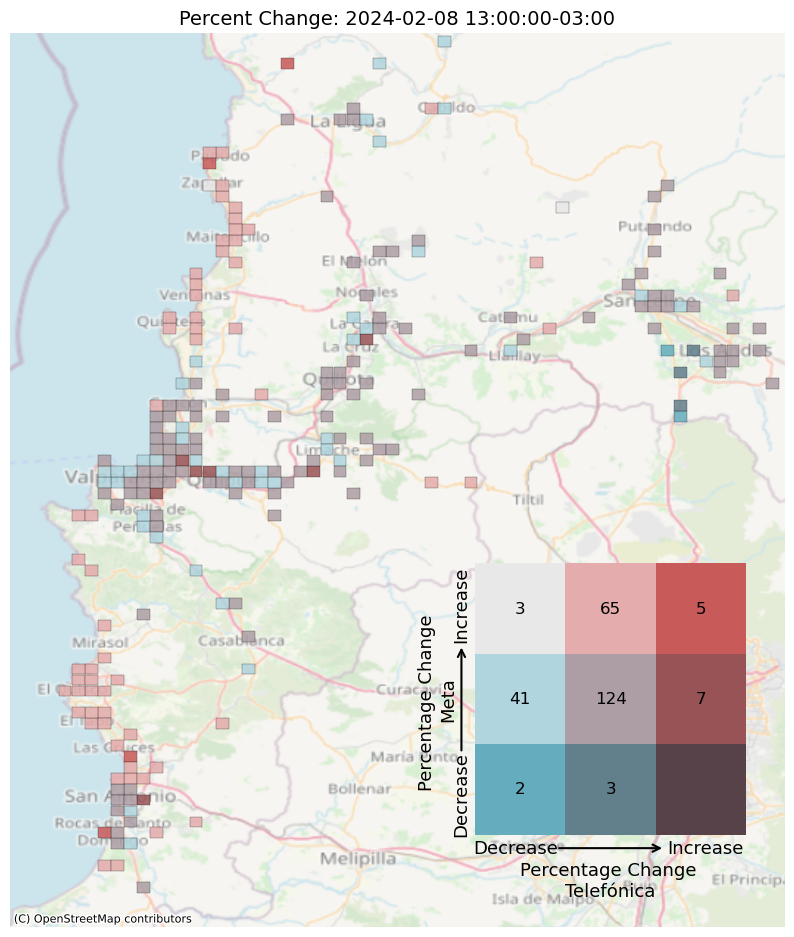

In [200]:
plot_column_from_dict_facecolor(binary_map, col_label_cmap_dict, jstevens_col_mats, 
                                value_counts=value_counts, time=datetime,
                                save=True)

In [118]:
final_tel = data_grids[['id', 'interval_start', 'diff_perc', 'z_score', 'z_score_clipped', 'unique_phone_ids_baseline', 'unique_phone_ids_crisis']]
final_tel=final_tel[final_tel['interval_start'] == '2024-02-08 13:00:00-03:00'].drop('interval_start', axis=1).reset_index(drop=True)

final_meta = df_crisis5[['id', 'date_time', 'percent_change', 'z_score', 'n_baseline', 'n_crisis']]
final_meta=final_meta[final_meta['date_time'] == '2024-02-08 13:00:00-03:00'].drop('date_time', axis=1).reset_index(drop=True)

merged_final = final_tel.merge(final_meta, on='id', suffixes=['_tel','_meta'])

In [119]:
required_keys = ['StableStable', 'IncreaseIncrease', 'DecreaseDecrease']
accuracy_results = pd.DataFrame(columns=['datetime', 'accuracy_zscore'])

for datetime in data_grids[(data_grids['interval_start']>='2024-02-04')&(data_grids['interval_start']<='2024-02-18')]['interval_start'].unique():
    
    final_tel = data_grids[['id', 'interval_start', 'diff_perc', 'z_score', 'z_score_clipped', 'unique_phone_ids_baseline', 'unique_phone_ids_crisis']]
    final_tel=final_tel[final_tel['interval_start'] == datetime].drop('interval_start', axis=1).reset_index(drop=True)

    final_meta = df_crisis5[['id', 'date_time', 'percent_change', 'z_score', 'n_baseline', 'n_crisis']]
    final_meta=final_meta[final_meta['date_time'] == datetime].drop('date_time', axis=1).reset_index(drop=True)

    merged_final = final_tel.merge(final_meta, on='id', suffixes=['_tel','_meta'])

    if not merged_final.empty:
        binary_map = merged_final
        binary_map = binary_map.merge(data_grids[['id', 'geometry']], on='id')
        binary_map = gpd.GeoDataFrame(binary_map, geometry='geometry')
        binary_map=binary_map.drop_duplicates().dropna().reset_index(drop=True)

        equal_count_classes(binary_map, ['z_score_clipped', 'z_score_meta'], zscore=True)

        bivariate_class_col(binary_map, ['z_score_clipped_class'], second_col='z_score_meta_class')

        value_counts=binary_map.bi_z_class.value_counts()
        
        # Ensure all required keys are present in value_counts
        
        for key in required_keys:
            if key not in value_counts:
                value_counts[key] = 0
        # Calculate the required fraction
        fraction = (value_counts['StableStable'] + value_counts['IncreaseIncrease'] + value_counts['DecreaseDecrease']) / value_counts.sum()
        fraction = round(fraction,3)

                # Create a new DataFrame for the current result
        current_result = pd.DataFrame({
            'datetime': [datetime],
            'accuracy_zscore': [fraction]
        })

        # Concatenate the current result with the results DataFrame
        accuracy_results = pd.concat([accuracy_results, current_result], ignore_index=True)

/tmp/ipykernel_40492/991330022.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  accuracy_results = pd.concat([accuracy_results, current_result], ignore_index=True)


In [120]:
current_result=[]

for datetime in data_grids[(data_grids['interval_start']>='2024-02-04')&(data_grids['interval_start']<='2024-02-18')]['interval_start'].unique():
    
    final_tel = data_grids[['id', 'interval_start', 'diff_perc', 'z_score', 'z_score_clipped', 'unique_phone_ids_baseline', 'unique_phone_ids_crisis']]
    final_tel=final_tel[final_tel['interval_start'] == datetime].drop('interval_start', axis=1).reset_index(drop=True)

    final_meta = df_crisis5[['id', 'date_time', 'percent_change', 'z_score', 'n_baseline', 'n_crisis']]
    final_meta=final_meta[final_meta['date_time'] == datetime].drop('date_time', axis=1).reset_index(drop=True)

    merged_final = final_tel.merge(final_meta, on='id', suffixes=['_tel','_meta'])

    if not merged_final.empty:
        binary_map = merged_final
        binary_map = binary_map.merge(data_grids[['id', 'geometry']], on='id')
        binary_map = gpd.GeoDataFrame(binary_map, geometry='geometry')
        binary_map=binary_map.drop_duplicates().dropna().reset_index(drop=True)

        equal_count_classes(binary_map, ['diff_perc', 'percent_change'], zscore=False)

        bivariate_class_col(binary_map, ['diff_perc_class'], second_col='percent_change_class')

        value_counts=binary_map.bi_diff_class.value_counts()
        
        # Ensure all required keys are present in value_counts
        
        for key in required_keys:
            if key not in value_counts:
                value_counts[key] = 0
        # Calculate the required fraction
        fraction = (value_counts['StableStable'] + value_counts['IncreaseIncrease'] + value_counts['DecreaseDecrease']) / value_counts.sum()
        fraction = round(fraction,3)

                # Create a new DataFrame for the current result
        current_result.append(fraction)


In [121]:
# Concatenate the current result with the results DataFrame
accuracy_results['accuracy_percentage'] = current_result

In [122]:
unique_dates = accuracy_results.drop_duplicates(subset=['datetime'])['datetime'].unique()
xticklabels2 = [date.strftime('%d \n%m \n%a ') if i % 3 == 0 else '' for i, date in enumerate(unique_dates)]

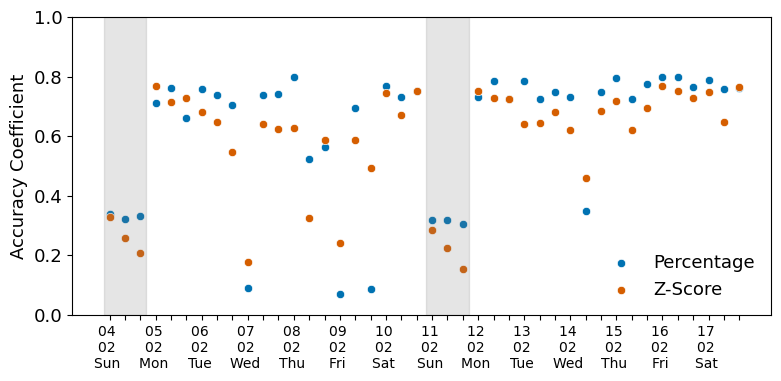

In [123]:
# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

# Plot Pearson correlation on the first subplot
sns.scatterplot(data=accuracy_results, x='datetime', y='accuracy_percentage', marker='o', ax=axs, label='Percentage',
                color='#0072B2')
sns.scatterplot(data=accuracy_results, x='datetime', y='accuracy_zscore', marker='o', ax=axs, label='Z-Score',
                color='#D55E00')
axs.set_title('')
axs.set_ylabel('Accuracy Coefficient')
axs.set_xlabel('')
axs.set_ylim(0, 1)

axs.set_xticks(unique_dates)
axs.set_xticklabels(xticklabels2, fontsize=10)

axs.axvspan('2024-02-04 02:00:00-03:00', '2024-02-05 00:00:00-03:00', color='gray', alpha=0.2)
axs.axvspan('2024-02-11 02:00:00-03:00', '2024-02-12 00:00:00-03:00', color='gray', alpha=0.2)

axs.legend(frameon=False, loc='lower right')

# Improve layout and show plot
plt.tight_layout()

plt.savefig('../visuals_created/meta_accuracies.pdf', bbox_inches='tight')
plt.show()

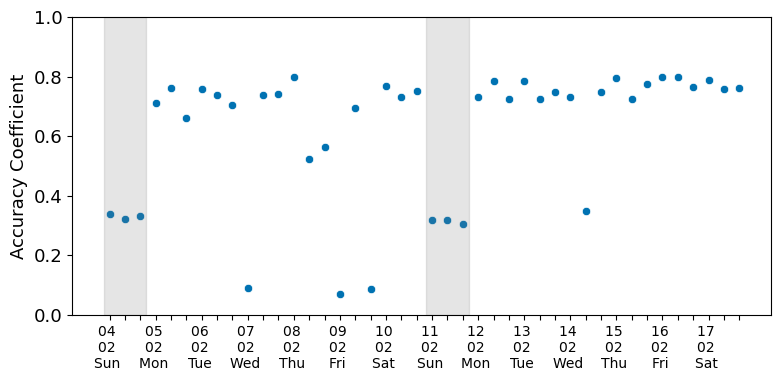

In [124]:
# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

# Plot Pearson correlation on the first subplot
sns.scatterplot(data=accuracy_results, x='datetime', y='accuracy_percentage', marker='o', ax=axs, label='Percentage',
                color='#0072B2', legend=False)
# sns.scatterplot(data=accuracy_results, x='datetime', y='accuracy_zscore', marker='o', ax=axs, label='Z-Score',
#                 color='#D55E00')
axs.set_title('')
axs.set_ylabel('Accuracy Coefficient')
axs.set_xlabel('')
axs.set_ylim(0, 1)

axs.set_xticks(unique_dates)
axs.set_xticklabels(xticklabels2, fontsize=10)

axs.axvspan('2024-02-04 02:00:00-03:00', '2024-02-05 00:00:00-03:00', color='gray', alpha=0.2)
axs.axvspan('2024-02-11 02:00:00-03:00', '2024-02-12 00:00:00-03:00', color='gray', alpha=0.2)

# axs.legend(frameon=False, loc='lower right')

# Improve layout and show plot
plt.tight_layout()

plt.savefig('../visuals_created/meta_accuracies_percentage.pdf', bbox_inches='tight')
plt.show()

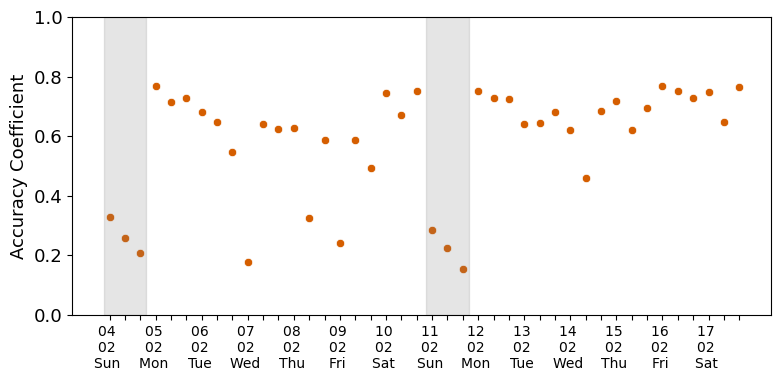

In [125]:
# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

# Plot Pearson correlation on the first subplot
# sns.scatterplot(data=accuracy_results, x='datetime', y='accuracy_percentage', marker='o', ax=axs, label='Percentage',
#                 color='#0072B2')
sns.scatterplot(data=accuracy_results, x='datetime', y='accuracy_zscore', marker='o', ax=axs, label='Z-Score',
                color='#D55E00', legend=False)
axs.set_title('')
axs.set_ylabel('Accuracy Coefficient')
axs.set_xlabel('')
axs.set_ylim(0, 1)

axs.set_xticks(unique_dates)
axs.set_xticklabels(xticklabels2, fontsize=10)

axs.axvspan('2024-02-04 02:00:00-03:00', '2024-02-05 00:00:00-03:00', color='gray', alpha=0.2)
axs.axvspan('2024-02-11 02:00:00-03:00', '2024-02-12 00:00:00-03:00', color='gray', alpha=0.2)
# axs.axvspan('2024-02-17 02:00:00-03:00', '2024-02-18 00:00:00-03:00', color='gray', alpha=0.2)

# axs.legend(frameon=False, loc='lower right')

# Improve layout and show plot
plt.tight_layout()

plt.savefig('../visuals_created/meta_accuracies_zscore.pdf', bbox_inches='tight')
plt.show()

In [144]:
# plot map use helper function
def plot_column_from_dict_facecolor(gdf, col_label_cmap_dict, jstevens_col_mats, value_counts, time,
                                    alpha=0.85, font_size=14, save=False, ax=ax):
    """
    Takes in gdf, column label cmap dictionary, and color matrix
    Also uses plot_inset_legend helper function to create plots
    """
    for col, label_cmap in col_label_cmap_dict.items():
        # Set figsize
        # fig, ax = plt.subplots(1, 1, figsize=(10, 12))

        # Plot with legend
        facecolor = gdf[label_cmap[1]].apply(lambda x: mcolors.to_rgba(x) if isinstance(x, str) else (1, 1, 1))
        gdf.plot(facecolor=facecolor, ax=ax, alpha=alpha, 
                 edgecolor='black', linewidth=0.2)

        # Set title
        ax.set_title(f'{label_cmap[0]}: {time}', fontdict={'size': font_size})

        ax.set_ylim( -33.8, -32.3)
        ax.set_xlim(-71.8, -70.5)

        # Turn off axis
        ax.axis('off')

        # Add basemap
        ctx.add_basemap(ax=ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

        for img in ax.get_images():
            img.set_alpha(0.6)

        # Get the corresponding color matrix
        index = list(col_label_cmap_dict.keys()).index(col)
        color_matrix = jstevens_col_mats[index][0]

        # Create inset legend
        ax_legend = ax.inset_axes([0.6, 0.08, 0.35, 0.35])
        legend_x_label = label_cmap[0].split(' ')[0]
        plot_inset_legend(ax_legend, color_matrix, value_counts=value_counts, x_label=f'% {legend_x_label}')

        # Remove edge color from legend
        ax_legend.set_frame_on(False)

        if save:
            # Save plots
            plt.savefig(f'../visuals_created/{col}_bi_{str(time)[:13]}.pdf', bbox_inches='tight')
        # else:
        #     plt.show()

Bbox(x0=0.125, y0=0.10999999999999999, x1=0.509297520661157, y1=0.88)
Bbox(x0=0.5797520661157023, y0=0.726, x1=0.8999999999999998, y1=0.88)


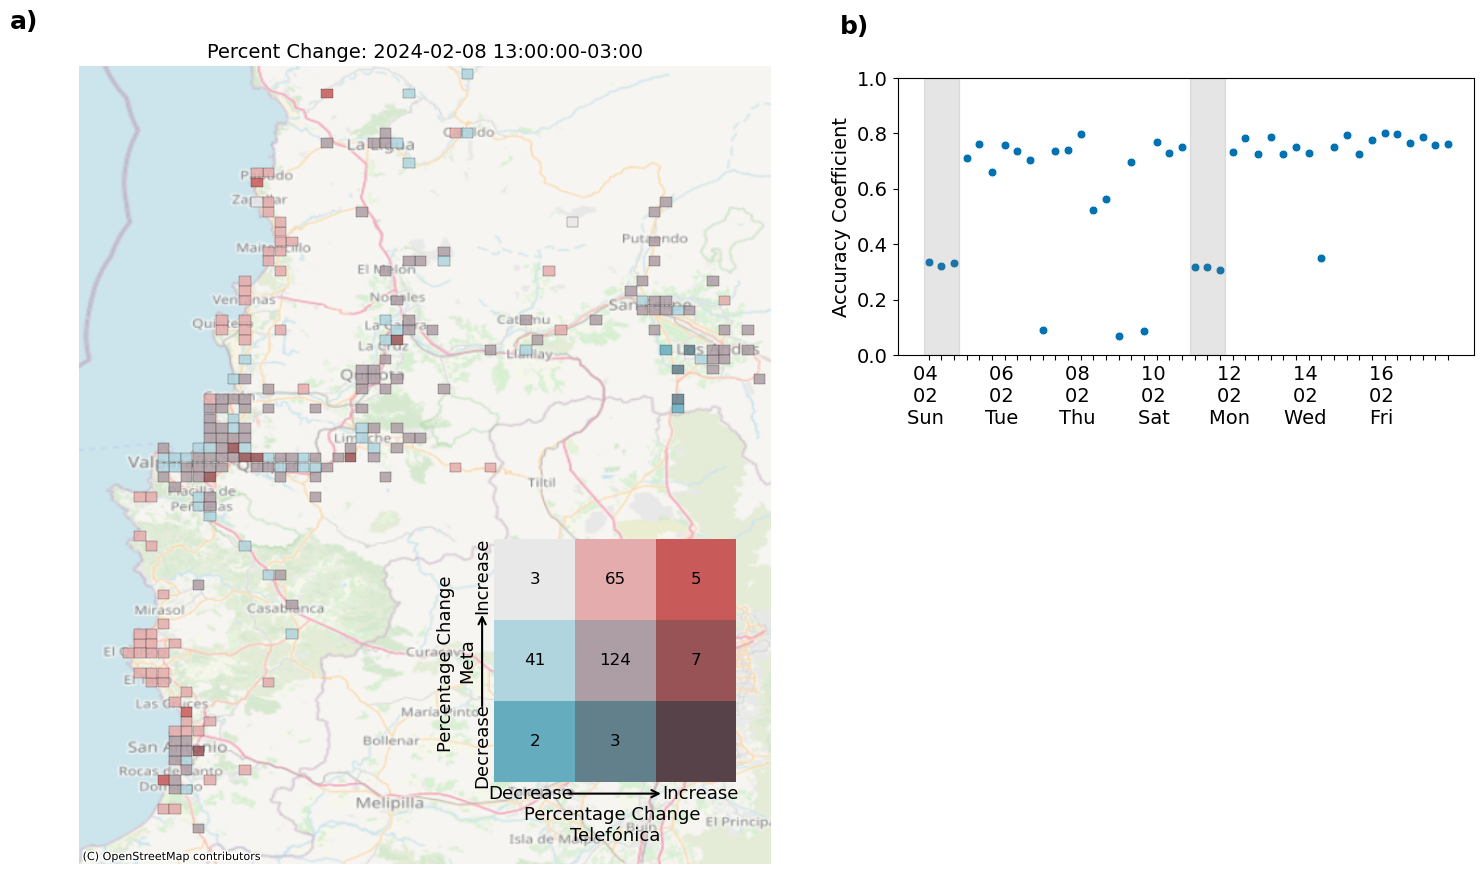

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplot_mosaic([
    ['a', 'b',],
    ['a', 'ee']], 
    #layout="constrained"
    figsize =(18, 18), height_ratios=[0.5,2],width_ratios=[1.2,1],
                            gridspec_kw={'wspace':0.2, 'hspace':0})# Create the subplots with the specified gridspec

for e in ['ee']: fig.delaxes(axs[e])

print(axs['a'].get_position())
print(axs['b'].get_position())

b = axs['b'].get_position()
#b.x0 = b.x0 + 0.15
# b.x1 = b.x1 - 0.05
b.y0 = b.y0 - 0.17
b.y1 = b.y1 - 0.17
axs['b'].set_position(b)


# Plot on the left subplot (wider one)
plot_column_from_dict_facecolor(binary_map, col_label_cmap_dict, jstevens_col_mats, 
                                value_counts=value_counts, time=datetime,
                                save=False, ax=axs['a'])

# Plot Pearson correlation on the right subplot (thinner one)
sns.scatterplot(data=accuracy_results, x='datetime', y='accuracy_percentage', marker='o', ax=axs['b'], label='Percentage',
                color='#0072B2', legend=False, s=40)

axs['b'].set_title('')
axs['b'].set_ylabel('Accuracy Coefficient', fontsize=14)
axs['b'].tick_params(axis='both', which='major', labelsize=14)
axs['b'].set_xlabel('')
axs['b'].set_ylim(0, 1)

axs['b'].set_xticks(unique_dates)
xticklabels3 = [date.strftime('%d \n%m \n%a ') if i % 6 == 0 else '' for i, date in enumerate(unique_dates)]
axs['b'].set_xticklabels(xticklabels3, fontsize=14)

# Add shaded regions for the Pearson correlation plot
axs['b'].axvspan('2024-02-04 02:00:00-03:00', '2024-02-05 00:00:00-03:00', color='gray', alpha=0.2)
axs['b'].axvspan('2024-02-11 02:00:00-03:00', '2024-02-12 00:00:00-03:00', color='gray', alpha=0.2)

plots_l = ['a)', 'b)']
k=1.04
for ia, ax in enumerate(fig.axes): 
    x,y = -0.1,k
    ax.text(x,y,  plots_l[ia],
        color = 'k',#'lightgreen',
        horizontalalignment='left',
        verticalalignment='bottom',
        weight = 'bold',
        transform=ax.transAxes,fontsize = 18)
    k+=0.1

plt.savefig(f'../visuals_created/meta_map_accuracy.pdf', bbox_inches='tight')
    
plt.show();


In [201]:
# Shut down the kernel to release memory
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(restart=False)

{'status': 'ok', 'restart': False}